In [65]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf
import imutils
import nibabel as nib
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib

from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

In [39]:
df = pd.read_csv('./metadata.csv')

In [40]:
df.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [41]:
img_size = 224
def cropper(img):

    img = np.uint8(img*255)   
    # ret, thresh = cv2.threshold(test_img, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    # ret, thresh = cv2.threshold(test_img, ret, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  
    contours,hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]  
    x = np.argsort(areas)   
    max_index = x[x.size - 1]
    cnt1=contours[max_index]
    second_max_index = x[x.size - 2]
    cnt2 = contours[second_max_index]   
      
    x,y,w,h = cv2.boundingRect(cnt1)
    p,q,r,s = cv2.boundingRect(cnt2)
    
    a=min(x,p)
    b=min(y,q)
    c=max(x+w,p+r)
    d=max(y+h,q+s)
    
    cropped= img[b:d, a:c]
    cropped = cv2.resize(cropped, dsize=(250,250), interpolation=cv2.INTER_AREA)
    
    points_lungs = []
    
    points_lungs.append(a); points_lungs.append(b); points_lungs.append(c); points_lungs.append(d)
    
    
    return(cropped, points_lungs)

In [42]:
def clahe_enhancer(img):
    xma=img.max()
    xmi=img.min()
    img=(img-xmi)/(xma-xmi)
    img = np.uint8(img*225)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    return clahe_img

In [43]:
all_points = []


def read_nii(filepath, data, string):
    
    global all_points
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    slices = array.shape[2]
    array = array[:,:,round(slices*0.2):round(slices*0.8)]
    array = np.reshape(np.rollaxis(array, 2),(array.shape[2],array.shape[0],array.shape[1],1))

    if string == "lungs":
        all_points = []

    for img_no in range(0, array.shape[0]):
        if string == 'lungs' and np.unique(array[img_no]).size == 1:
            continue
        img = cv2.resize(array[img_no], dsize=(img_size, img_size), interpolation=cv2.INTER_AREA)
        xmax, xmin = img.max(), img.min()
        img = (img - xmin)/(xmax - xmin)

        if string == 'lungs':
            img[img>0]=1
            img, points= cropper(img)
            all_points.append((points[0], points[1], points[2], points[3]))
            continue 

        if string == "cts" and img_no < len(all_points):
            img = clahe_enhancer(img)   
            a,b,c,d = all_points[img_no]
            img1 = img[b:d, a:c]
            img = cv2.resize(img1, dsize=(250,250), interpolation=cv2.INTER_AREA)
            

        if string == "infections" and img_no < len(all_points):
            a,b,c,d = all_points[img_no]
            img = np.uint8(img*255)
            img1 = img[b:d, a:c]
            img = cv2.resize(img1, dsize=(250,250), interpolation=cv2.INTER_AREA)
            
        img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)
        data.append(img)

In [44]:
cts = []
lungs = []
infections = []
for i in range(0, 3):
    read_nii(df.loc[i,'lung_mask'],lungs,"lungs")
    read_nii(df.loc[i,'ct_scan'],cts,"cts")
    read_nii(df.loc[i,'infection_mask'],infections,"infections")


<ipython-input-43-3ffcf4256310>:22: RuntimeWarning: invalid value encountered in true_divide
  img = (img - xmin)/(xmax - xmin)


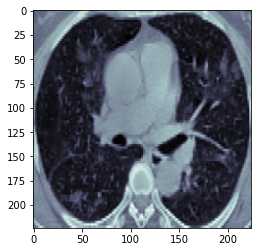

In [63]:
fig=plt.figure()
plt.imshow(cts[120],cmap='bone')
plt.show()

In [64]:
y_label = []
for i in range(0, len(infections)):
  if len(np.unique(infections[i]))!=1:
    y_label.append(1)
  else:
    y_label.append(0)
print(y_label.count(0), y_label.count(1))

24 397


In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cts=np.array(cts)
cts=np.uint8(cts)
cts = cts.reshape(len(cts), img_size,img_size,1)
y_label = np.array(y_label)


x_train, x_valid, y_train, y_valid = train_test_split(cts, y_label, test_size = 0.3, random_state=42)

aug = ImageDataGenerator( 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    horizontal_flip=True, 
    fill_mode="nearest"
    )


In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(img_size,img_size,1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same" ))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))             
model.add(Dense(1 , activation='sigmoid'))      

batch_size = 32
epochs = 50
best_val_auc = -1


filepath_acc = "covid_weights_val_acc.hdf5"
checkpoint_acc = ModelCheckpoint(filepath_acc, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0003), metrics=["acc"])

In [ ]:
weights = class_weight.compute_class_weight('balanced',
                                            np.unique(y_train),
                                            y_train)
weights=dict(enumerate(weights))


results = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_valid, y_valid) ,
                    steps_per_epoch = len(x_train)//batch_size,
                    callbacks = [checkpoint_acc],
                    class_weight=weights)

In [ ]:
model.load_weights("covid_weights_val_acc.hdf5")
score = model.evaluate(x_valid, y_valid, batch_size=32)
print("test loss:" , score[0], "\ntest accuracy:" , score[1])

In [ ]:
rcParams['figure.figsize'] = 10,7
plt.grid('True')
plt.plot(results.history['loss'], color='m')
plt.plot(results.history['val_loss'], color='k')
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()